<a href="https://colab.research.google.com/github/genaiconference/Agentic_RAG_Workshop/blob/main/06_Agentic_RAG_E2E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Agentic RAG

In [1]:
!git clone https://github.com/genaiconference/Agentic_RAG_Workshop.git

Cloning into 'Agentic_RAG_Workshop'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 95 (delta 43), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (95/95), 2.26 MiB | 5.35 MiB/s, done.
Resolving deltas: 100% (43/43), done.


## Setup and Installations
Install necessary libraries for document processing, data handling, and interacting with Azure Document Intelligence and OpenAI.

In [2]:
!pip install -r /content/Agentic_RAG_Workshop/requirements.txt

## Load Environment Variables and Initialize Clients
Load environment variables containing API keys and endpoint information, and initialize the Azure Document Intelligence and OpenAI clients.

In [1]:
import os

os.chdir("/content/Agentic_RAG_Workshop/")

from dotenv import load_dotenv
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

load_dotenv()

llm = ChatOpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
    model="gpt-4.1",
    temperature=0,
)

embeddings = OpenAIEmbeddings(
    api_key=os.getenv("OPENAI_API_KEY"),
    model="text-embedding-3-small"
)

## Load Parent Docs

In [2]:
import pickle

with open("parent_docs_and_ids.pkl", "rb") as f:
    parent_data = pickle.load(f)

parent_docs = parent_data["parent_docs"]
doc_ids = parent_data["doc_ids"]

## Load Child docs

In [3]:
from multivector_utils import create_child_documents, generate_summaries, generate_hypothetical_questions

id_key = "doc_id"

child_docs = create_child_documents(parent_docs, doc_ids, id_key)
summaries = generate_summaries(parent_docs, llm, id_key, doc_ids)
questions = generate_hypothetical_questions(parent_docs, id_key, doc_ids)

## Define VectorStore

**Azure AI Search**

In [4]:
from langchain_community.vectorstores.azuresearch import AzureSearch

index_name: str = "agentic-rag-workshop"
search_type: str = "semantic_hybrid"

vectorstore: AzureSearch = AzureSearch(azure_search_endpoint=os.getenv("AZURE_SEARCH_ENDPOINT"),
                                            azure_search_key=os.getenv("AZURE_SEARCH_KEY"),
                                            index_name=index_name,
                                            search_type=search_type,
                                            semantic_configuration_name="agentic-rag-semantic-config",
                                            embedding_function=embeddings.embed_query)

**Chroma**

In [5]:
from langchain.vectorstores import Chroma

vectorstore = Chroma(
    collection_name="full_documents", embedding_function=embeddings
)

# Add child_docs, sumamries, questions to the vectorstore
vectorstore.add_documents(documents=child_docs)
vectorstore.add_documents(documents=summaries)
vectorstore.add_documents(documents=questions)

/tmp/ipython-input-383506511.py:3: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


['982af4dd-d38c-4e51-aae2-5126daa0fd54',
 '999e0d02-e23b-408a-9d11-4830ff216396',
 '131aa9d4-afb0-45bb-a098-65743d3946aa',
 'f29980e2-2d55-40d1-be40-3337223cc971',
 '4072a330-9da4-4711-8ffc-ff7a5b0ff556',
 '03bd5c7e-6d16-4cc3-b3ac-e4102bf68b97',
 '46a73ff2-9a23-4aca-9b53-c72bdf02f758',
 'bdd467a1-cb3b-4fcf-ac0c-0010f17b2b2e',
 '71027a6e-34fd-4cce-b96f-6046e5a01198',
 '3fe95961-f33f-4c4d-9ccb-e0213681334a',
 '5c596b58-5668-454c-a14c-49a131601691',
 'e15f28f5-b79f-4321-adb1-cba052b5f6db',
 '6a3942b9-da09-42a4-8524-17c0f1e6897a',
 'd0735e76-3cbe-4947-a1d4-61867e013236',
 'df0310c1-685c-40f8-9430-fc1b57b6f8fb',
 '7072c29e-3caa-48a0-a139-2c5841430560',
 'a2ecd7cb-2ac3-4910-b2fb-0e94eb9a6213',
 '9145812d-0338-483d-a53d-5475d1e330f2',
 'dd0a291c-f0cc-4255-991e-b2598de104d6',
 '4a269db7-3f31-4119-a729-b29285908915',
 'e33d5fc7-5b31-481b-9628-4740017cdfd7',
 'f520bc5f-bf35-4f52-b532-18b21f6d0fbd',
 'b5269391-75e8-495e-b48a-62a3cdd42e11',
 '95b9886d-381b-40a4-bdf3-3962d6405080',
 '759f68c7-932b-

## Create Retrivers for Internal Documents

In [5]:
from multivector_utils import create_MVR

Leave_Policy_retriever = create_MVR(parent_docs, doc_ids, vectorstore, f"source eq 'Leave Policy'" )

Insurance_Policy_retriever = create_MVR(parent_docs, doc_ids, vectorstore, f"source eq 'Insurance Policy'" )

## Create Retrievers as Tools

In [6]:
from langchain.tools.retriever import create_retriever_tool

Leave_Policy_tool = create_retriever_tool(retriever=Leave_Policy_retriever,
                            name = 'Leave_Policy_Retriever',
                            description="Use this tool to answer questions related to Leave Policies of a company.")

Insurance_Policy_tool = create_retriever_tool(retriever=Insurance_Policy_retriever,
                            name = 'Insurance_Policy_Retriever',
                            description="Use this tool to answer questions related to Health Insurance Policies of a company.")

### Inside any Retriver or Web search API as a tool

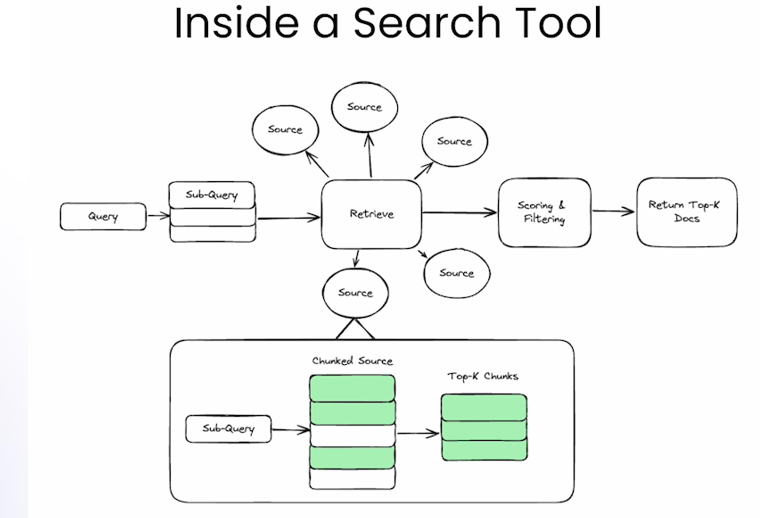

## Create WEB Search Tool

In [7]:
from langchain_tavily import TavilySearch

# Initialize Tavily Search Tool
tavily_search_tool = TavilySearch(
    tavily_api_key=os.getenv('TAVILY_API_KEY'),
    max_results=5,
    topic="general",
)

# Now Let's understand the step by step creation of a Graph
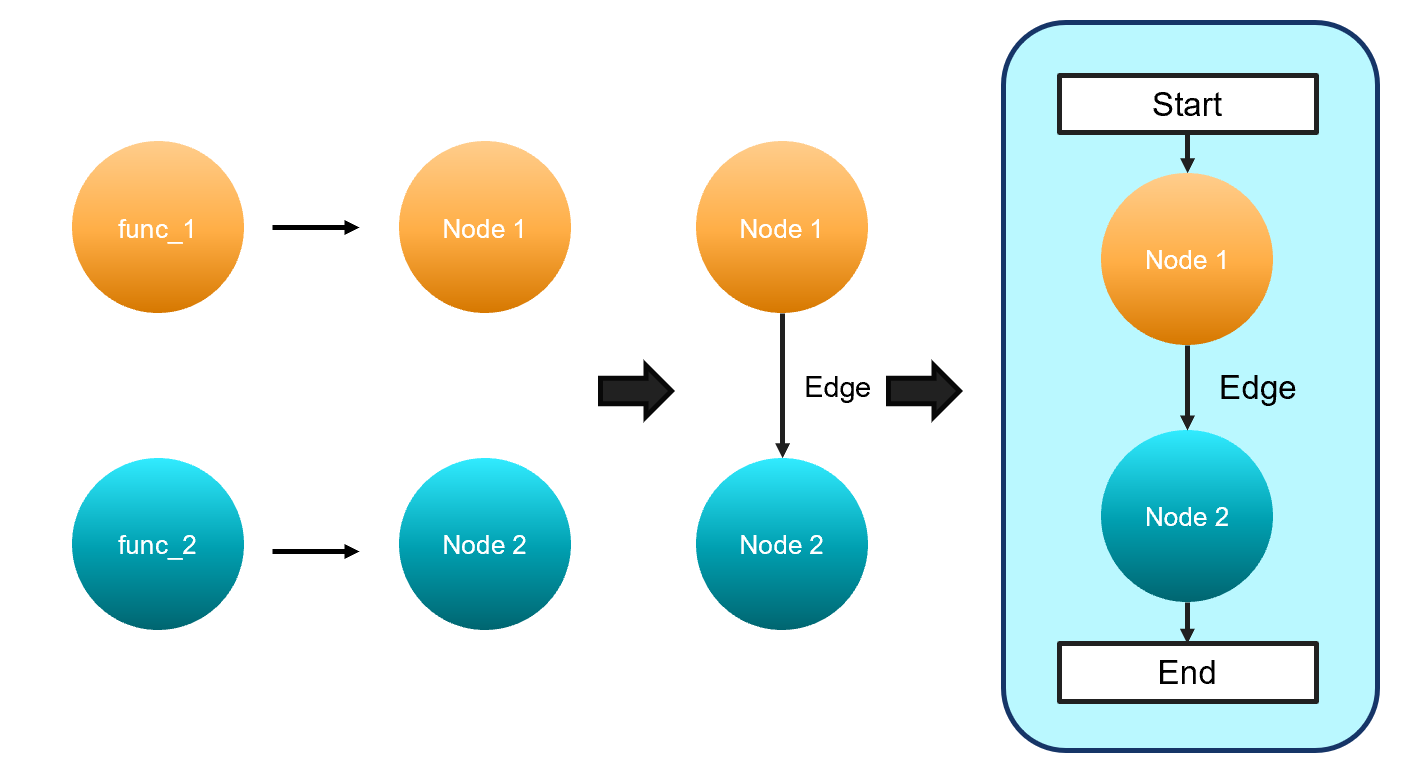

## Graph Evolution: From Basic to Complex

The below information outlines the evolution of a graph structure, starting from a simple three-node configuration and progressively adding complexity through the introduction of new node types. Each step builds upon the previous one, introducing new functionalities and pathways within the graph. The evolution covers the addition of Web sources, generic data sources, query rerouting, and query rewriting capabilities.

### Step-1: Basic

The initial graph structure is the most fundamental. It consists of a linear flow of information:


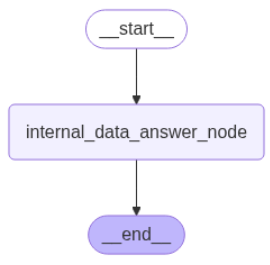


- **start node:** Represents the entry point of the process. This could be a user query, an event trigger, or any other initiating factor.


- **Internal sources node:** Represents a data source that is internal to the system. This could be a database, a file system, or any other local data repository.


- **end node:** Represents the termination point of the process. This could be the delivery of results to the user, the completion of a task, or any other concluding action.


This basic structure represents a simple data retrieval process where the start node triggers a query to the internal sources, and the results are then passed to the end node.

### Step-2: Add WEB Node

The second step introduces an alternative data source: the Web. The graph now has two possible paths:

- **WEB Answer Node:** Represents an external data source accessible via the internet. This could be a web API, a website, or any other online data repository.

The addition of the WEB Node allows the system to retrieve data from external sources.

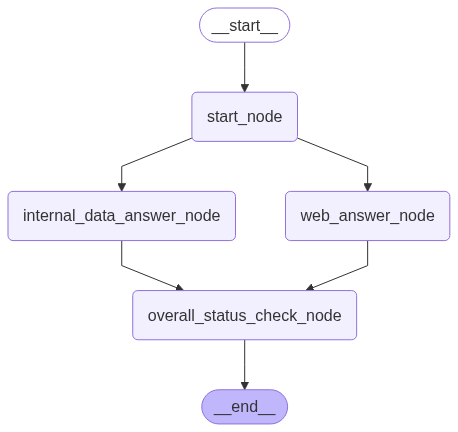

1. **`start_node`** is the single entry point.
2. It passes the `GraphState` forward without changing it.
3. From `start_node`, the flow **fans out** to two nodes in parallel:

   * `internal_data_answer_node`
   * `web_answer_node`
4. Both nodes process the same starting state independently.
5. When **both finish**, execution **fans in** to `overall_status_check_node`.
6. `overall_status_check_node` can see results from both previous nodes.
7. The graph ends after `overall_status_check_node` runs.


### Step-3: Add Generic Node

This step introduces a more generalized data source, allowing for flexibility in data retrieval:

- **Generic Answer Node:** Represents a generic data source.

This allows the system to answer from it's foundational knowledge.

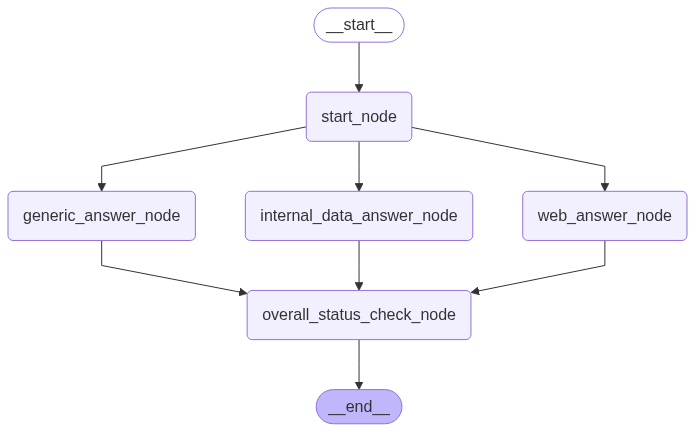


1. **`start_node`** begins the graph.
2. It sends the same state to **three nodes in parallel**:

   * `internal_data_answer_node`
   * `web_answer_node`
   * `generic_answer_node`
3. Each node works independently.
4. **All three** send results to `overall_status_check_node`.
5. `overall_status_check_node` runs only when all three are done.
6. The graph finishes after that.


### Step-4: Add Query Rerouter Node

To improve efficiency and accuracy, a Query Rerouter Node is introduced.

- **Query_rerouter Node:** This node analyzes the incoming query and determines the most appropriate route to use. It acts as a decision point, directing the query to either the Generic or Internal sources node or the WEB Node based on predefined rules.

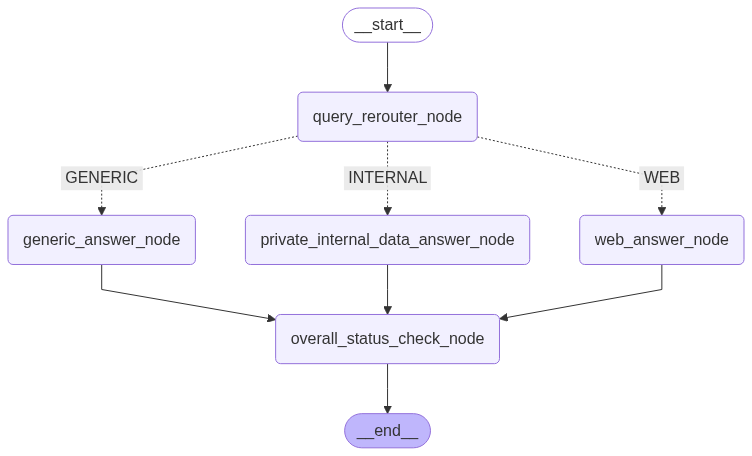



# Step-5: Add Query Rewriter Node

The final step introduces a Query Rewriter Node to optimize the query before it is sent to the data sources

- **Query Rewriter Node:** This node modifies the incoming query based on the previous conversation history to improve its performance or accuracy. The rewritten query is then sent to further nodes in the graph.

In summary, the graph evolves from a simple linear structure to a more complex and intelligent structure.

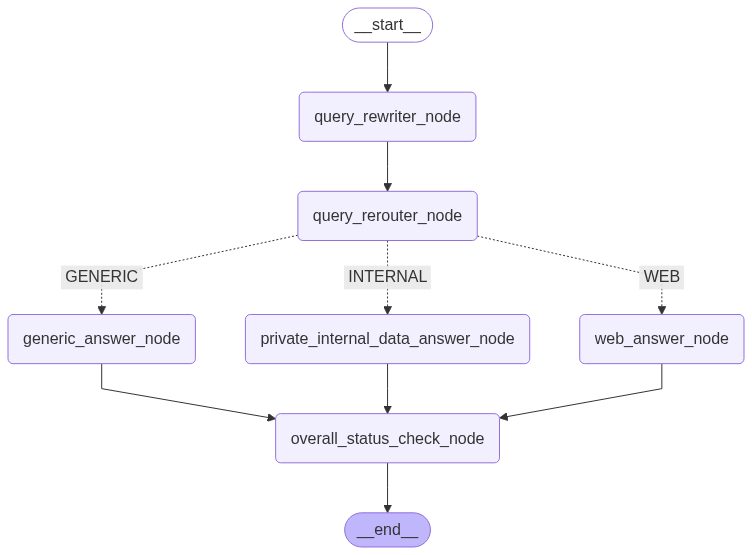

1. **`query_rewriter_node`** is the **entry point**.
2. It rewrites the incoming query and passes it to **`query_rerouter_node`**.
3. **`query_rerouter_node`** decides where the query should go, based on `x["query_routed_to"]`.
4. The routing choices are:

   * `"INTERNAL"` → `private_internal_data_answer_node`
   * `"WEB"` → `web_answer_node`
   * `"GENERIC"` → `generic_answer_node`
5. Regardless of which path is taken, that path’s node connects to `overall_status_check_node`.
6. `overall_status_check_node` runs after the selected path is complete.
7. The graph **finishes** after `overall_status_check_node`.

## Define the functions to later convert them as Graph Nodes

In [8]:
import prompts
from typing import List
from pydantic import BaseModel, Field
from simple_colors import *
from langchain_core.prompts import PromptTemplate
from IPython.display import Markdown
from agent_utils import get_react_agent
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langchain_community.callbacks import get_openai_callback

# Function to rewrite queries
def rewrite_query(_llm, prompt, conversation_history: str, user_query: str) -> str:
    """
    Rewrites the user query based on the conversation
    """
    # Prompt template
    prompt_template = PromptTemplate(
        template=prompt,
        input_variables=["question"],
    )

    # LCEL chain
    query_rewriter_chain = prompt_template | _llm

    # Invoke the chain
    result = query_rewriter_chain.invoke({
        "conversation_history": conversation_history,
        "user_query": user_query
    })
    return result.content.strip()


def query_rewriter_node(state):
    """Use this tool to rewrite the original query based on the conversation history."""
    observation = rewrite_query(llm, prompts.QUERY_REWRITER_PROMPT, state['conversation_history'], state['question'])

    print("------ENTERING: QUERY REWRITER NODE------")
    print(f"------RESULT: {observation}------")

    return {"original_question":state['question'], "question": observation}


class RerouterCheck(BaseModel):
    """Query Rerouter Output."""
    rerouter_output: str = Field(description="Given a user question, route the question to either 'INTERNAL' OR 'GENERIC' OR 'WEB'")


def query_rerouter(_llm, prompt, conversation_history, question) -> RerouterCheck:
    """Run source detection using LLM with structured output."""

    # Output parser
    parser = PydanticOutputParser(pydantic_object=RerouterCheck)

    # Prompt template
    prompt = PromptTemplate(
        template=prompt,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    query_rerouter_chain = prompt | _llm | parser

    result = query_rerouter_chain.invoke({
        "conversation_history": conversation_history,
         "question": question
        }
        )
    return result.rerouter_output.strip()


def query_rerouter_node(state):
    """Use this tool to detect top sources based on the classification rules & conversation history."""
    observation = query_rerouter(llm, prompts.QUERY_REROUTER_PROMPT, state['conversation_history'], state['question'])

    print("------ENTERING: QUERY REROUTER NODE------")
    print(f"------RESULT: {observation}------")

    return {"query_routed_to": observation}


def get_generic_answer(_llm, prompt, conversation_history, question):
    """get generic answer"""
    prompt_template = PromptTemplate(
        template=prompt,
        input_variables=["question"],
    )
    generic_answer_chain = prompt_template | _llm

    result = generic_answer_chain.invoke({
        "conversation_history": conversation_history,
        "question": question
    })
    return result.content.strip()



def generic_answer_node(state):
    """Use this tool to answer user generic questions"""
    print("------ENTERING: GENERIC ANSWER NODE------")

    final_answer = get_generic_answer(llm, prompts.GENERIC_ANSWER_PROMPT, state['conversation_history'], state['question'])

    return {"conversation_history": [HumanMessage(content=state["question"]),
                                     AIMessage(content=final_answer)],
                                     "final_answer": final_answer}


def web_answer_node(state):
    """Use this tool when you need to answer questions related to current events and latest happenings"""
    print("------ENTERING: WEB ANSWER NODE------")
    tools = [tavily_search_tool]
    generate_agent = get_react_agent(
        llm,
        tools,
        prompts.REACT_PROMPT,
        verbose=True,
    )
    with get_openai_callback() as cb:
        answer = generate_agent.invoke(
            {
                "input": state["question"],
                "conversation_history": state["conversation_history"],
                "SYSTEM_PROMPT": prompts.SYSTEM_PROMPT,
                "GENERAL_INSTRUCTIONS": prompts.General_Instructions,
                "SPECIAL_INSTRUCTIONS": prompts.WEB_Special_Instructions,
            }
        )

    return {"conversation_history": [HumanMessage(content=state["question"]),
                                     AIMessage(content=answer["output"])],
            "final_answer": answer["output"]}


def private_internal_data_answer_node(state):
    """Use this tool to answer any questions related to leave policies of the compny"""
    print("------ENTERING: PRIVATE INTERNAL DATA ANSWER NODE------")
    tools = [Leave_Policy_tool, Insurance_Policy_tool, tavily_search_tool]
    generate_agent = get_react_agent(
        llm,
        tools,
        prompts.REACT_PROMPT,
        verbose=True,
    )
    with get_openai_callback() as cb:
        answer = generate_agent.invoke(
            {
                "input": state["question"],
                "conversation_history": state["conversation_history"],
                "SYSTEM_PROMPT": prompts.SYSTEM_PROMPT,
                "GENERAL_INSTRUCTIONS": prompts.General_Instructions,
                "HEALTH_INSURANCE_SPECIAL_INSTRUCTIONS": prompts.Health_Special_Instructions,
                "LEAVE_POLICY_SPECIAL_INSTRUCTIONS": prompts.Leave_Special_Instructions,
            }
        )

    return {"conversation_history": [HumanMessage(content=state["question"]),
                                     AIMessage(content=answer["output"])],
            "final_answer": answer["output"]}


def overall_status_check_node(state):
    """Use this tool to check the overall status and update the config settings"""
    print("------ENTERING: OVERALL STATUS CHECK NODE------")
    final_answer = state['final_answer']
    observation = "Completed"
    print("-------------------------------- {} --------------------------------".format(black("Final Answer", ['bold'])))
    display(Markdown(final_answer))

    return {"overall_status_check": observation, 'final_answer':final_answer}

## Define the GraphState

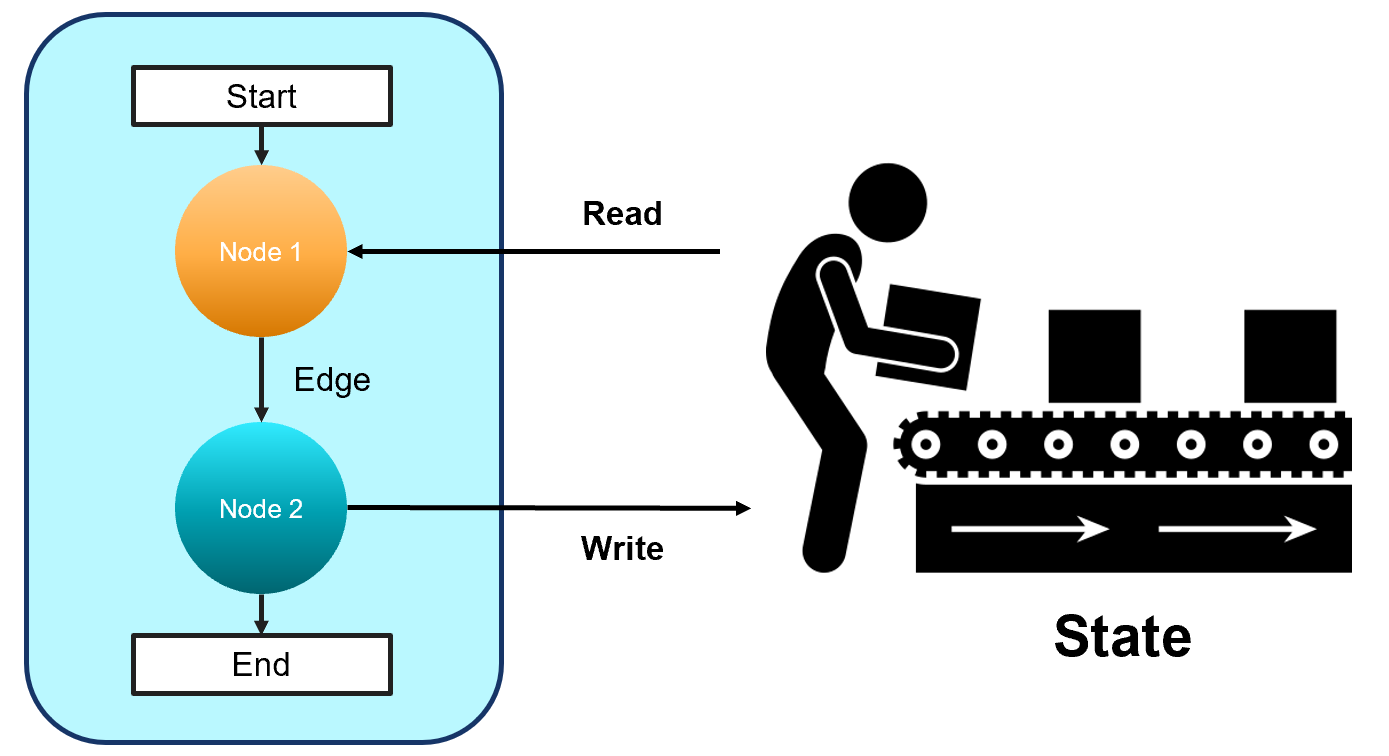

In [9]:
from typing_extensions import TypedDict
from typing import Annotated, List
import operator
from langchain_core.messages import AnyMessage


class GraphState(TypedDict):
    """
    Represents the state of our graph.
    """

    original_question: str
    query_routed_to: str
    overall_status_check: str

    question: str
    final_answer: str
    conversation_history: Annotated[list[AnyMessage], operator.add]

## Now construct the Graph architecture
### First add all the nodes to the Graph

In [10]:
from langgraph.graph import StateGraph

builder = StateGraph(GraphState)
builder.add_node("query_rewriter_node", query_rewriter_node)
builder.add_node("query_rerouter_node", query_rerouter_node)
builder.add_node("generic_answer_node", generic_answer_node)
builder.add_node("web_answer_node", web_answer_node)
builder.add_node("private_internal_data_answer_node", private_internal_data_answer_node)
builder.add_node("overall_status_check_node", overall_status_check_node)

### Now define the workflow

In [11]:
from langgraph.checkpoint.sqlite import SqliteSaver

builder.set_entry_point("query_rewriter_node")

builder.add_edge("query_rewriter_node", "query_rerouter_node")

builder.add_conditional_edges(
    "query_rerouter_node",
    lambda x: x["query_routed_to"],
    {
        "INTERNAL": "private_internal_data_answer_node",
        "WEB": "web_answer_node",
        "GENERIC": "generic_answer_node",
    },
)

builder.add_edge("generic_answer_node", "overall_status_check_node")
builder.add_edge("web_answer_node", "overall_status_check_node")
builder.add_edge("private_internal_data_answer_node", "overall_status_check_node")

builder.set_finish_point("overall_status_check_node")

# Correctly obtain the checkpointer object
memory_context_manager = SqliteSaver.from_conn_string(":memory:")
memory = memory_context_manager.__enter__()  # Enter the context manager to get the checkpointer
graph = builder.compile(checkpointer=memory)

## Let's visualize the Graph

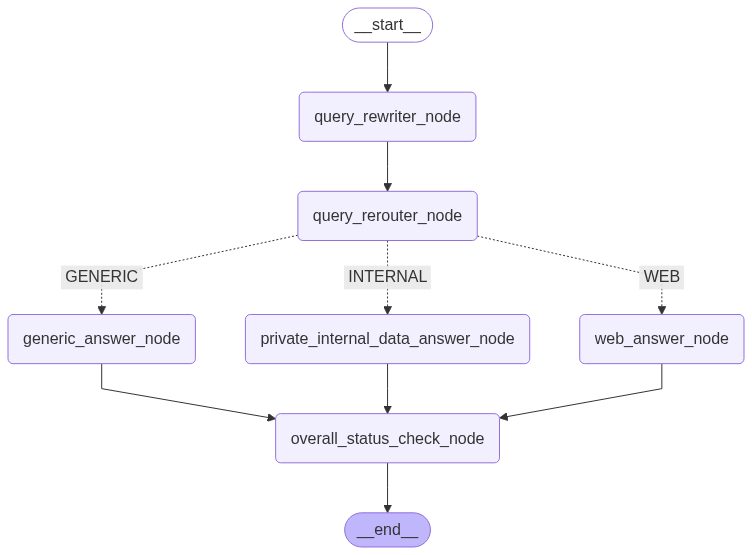

In [82]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Let's ask the questions now!
Thread ID helps in setting the memory thread

In [12]:
def run_graph(question, thread_id):
    inputs = {"question": question}
    thread = {"configurable": {"thread_id": str(thread_id)}}
    for output in graph.stream(inputs, thread, stream_mode='values'):
        pass

In [76]:
question = "Who are you?"
run_graph(question, 14)

------ENTERING: QUERY REWRITER NODE------
------RESULT: Who are you?------
------ENTERING: QUERY REROUTER NODE------
------RESULT: GENERIC------
------ENTERING: GENERIC ANSWER NODE------
------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


Hello! I’m Saha, your go-to insight engine for all things related to Leave and Insurance Policy documents. If you have questions about these topics, I’m here to help!

In [77]:
question = "tell me what you can do?"
run_graph(question, 14)

------ENTERING: QUERY REWRITER NODE------
------RESULT: tell me what you can do?------
------ENTERING: QUERY REROUTER NODE------
------RESULT: INTERNAL------
------ENTERING: PRIVATE INTERNAL DATA ANSWER NODE------


> Entering new ParallelAgentExecutor chain...
**Thought:**  
I need to check both leave and insurance policy capabilities to answer comprehensively.

**Action 1:** Leave_Policy_Retriever  
**Action Input 1:** what can you do?

**Action 2:** Insurance_Policy_Retriever  
**Action Input 2:** what can you do?

**Observation 1:**  
I can provide information on leave types, eligibility, accrual, carryover, approval process, documentation requirements, and special leave categories as per the company's leave policy.

**Observation 2:**  
I can provide details on health insurance coverage, eligibility, claim process, covered treatments, exclusions, reimbursement limits, and emergency protocols as per the company's insurance policy.

**Final Thought:**  
I now have the scope of both 

**  
**Saha can help you with:**  
- 📅 Leave policies: Types of leave, eligibility, accrual, carryover, approval, and documentation requirements.  
- 🏥 Insurance policies: Coverage details, eligibility, claim process, covered treatments, exclusions, and reimbursement limits.

In [13]:
question = "I am adopting a kid, wondering how many leaves can I avail? Also list down the various insurance benefits that my family can avail?"
run_graph(question, 14)

------ENTERING: QUERY REWRITER NODE------
------RESULT: I am adopting a kid, wondering how many leaves can I avail? Also list down the various insurance benefits that my family can avail?------
------ENTERING: QUERY REROUTER NODE------
------RESULT: INTERNAL------
------ENTERING: PRIVATE INTERNAL DATA ANSWER NODE------


> Entering new ParallelAgentExecutor chain...
Thought: I need to check the leave policy for adoption leave entitlements and the insurance policy for family coverage and benefits. I will use Leave_Policy_Retriever and Insurance_Policy_Retriever in parallel, then use tavily_search for any recent updates or additional info.
Action 1: Leave_Policy_Retriever
Action Input 1: adoption leave entitlement
Action 2: Insurance_Policy_Retriever
Action Input 2: insurance benefits for employee family
Action 3: tavily_search
Action Input 3: latest adoption leave and family insurance benefits company policy

HttpResponseError: (FeatureNotSupportedInService) Semantic search is not enabled for this service.
Parameter name: queryType
Code: FeatureNotSupportedInService
Message: Semantic search is not enabled for this service.
Parameter name: queryType
Exception Details:	(SemanticQueriesNotAvailable) Semantic search is not enabled for this service.
	Code: SemanticQueriesNotAvailable
	Message: Semantic search is not enabled for this service.